### Overview
* **SARIMAX** - Seasonality + ARIMA + External regressors (holiday flags, strategic shifts etc.)
---

### Example 1 - Using Bike Sharing [dataset](https://www.kaggle.com/datasets/contactprad/bike-share-daily-data)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.options.display.max_columns = None

# Time-series
from statsmodels.tsa.stattools import adfuller
# from statsmodels.graphics.tsaplots import month_plot, quarter_plot

# Model
from pmdarima import auto_arima

# Error Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Suppress 'futurewarnings' from Statsmodels and TSA
import warnings
warnings.filterwarnings("ignore")

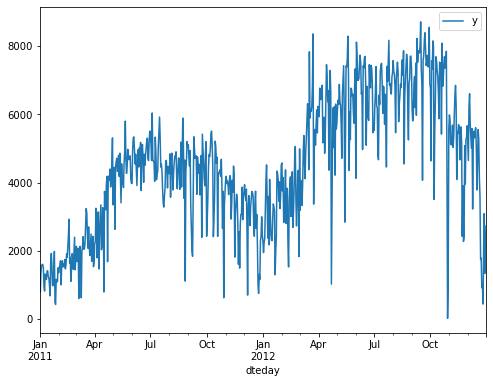

In [4]:
df = pd.read_csv('data/daily_bike_sharing.csv', index_col='dteday', parse_dates=True)
df = df.loc[:,['cnt', 'holiday', 'workingday','weathersit', 'temp', 'atemp', 'hum', 'windspeed']]
df = df.rename(columns={'cnt':'y'})
df = df.asfreq('D')
df['y'].plot(figsize=(8,6), legend=True);

### Stationarity

In [6]:
# If p-value is less than 0.05, time series is considered stationary
print(adfuller(df['y'])[1])

0.34274344033921944


### Separating Time Series & Exogenous variables

In [7]:
# Train, Test split
test_period = 31
train = df.iloc[:-test_period, :]
test  = df.iloc[-test_period:, :]
print(train.shape, test.shape)

(700, 8) (31, 8)


In [8]:
train_exog = train.drop(columns='y')
test_exog  = test.drop(columns='y')
print(train_exog.shape, test_exog.shape)

(700, 7) (31, 7)


In [9]:
train.head()

,y,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,,
2011-01-01,985,0,0,2,0.344167,0.363625,0.805833,0.160446
2011-01-02,801,0,0,2,0.363478,0.353739,0.696087,0.248539
2011-01-03,1349,0,1,1,0.196364,0.189405,0.437273,0.248309
2011-01-04,1562,0,1,1,0.200000,0.212122,0.590435,0.160296
2011-01-05,1600,0,1,1,0.226957,0.229270,0.436957,0.186900


In [10]:
train_exog.head()

,holiday,workingday,weathersit,temp,atemp,hum,windspeed
dteday,,,,,,,
2011-01-01,0,0,2,0.344167,0.363625,0.805833,0.160446
2011-01-02,0,0,2,0.363478,0.353739,0.696087,0.248539
2011-01-03,0,1,1,0.196364,0.189405,0.437273,0.248309
2011-01-04,0,1,1,0.200000,0.212122,0.590435,0.160296
2011-01-05,0,1,1,0.226957,0.229270,0.436957,0.186900


In [11]:
model = auto_arima(y = train['y'], X = train_exog, m = 7, seasonal = True)  # no fit() needed

In [12]:
type(model)

pmdarima.arima.arima.ARIMA

In [13]:
model.summary()   # lecture best fit was SARIMA(0,1,3), although with similar coeff values/ p-values
                  # Exogenous coefficients provide directional impact

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  700
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -5599.158
Date:                Mon, 13 Jun 2022   AIC                          11218.315
Time:                        17:27:49   BIC                          11263.812
Sample:                    01-01-2011   HQIC                         11235.904
                         - 11-30-2012                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holiday     -237.0356    129.349     -1.833      0.067    -490.555      16.484
workingday    89.9806     57.981      1.552      0.121     -23.659     203.621
weathersit  -462.8958     49.204     -9.408      0.000    -559.335    -366.457
temp        3421.8436   1157.319      2.957      0.003    1153.540    5690.147
atemp       1971.3621   1182.145      1.668      0.095    -345.600    4288.324
hum        -2282.1299    194.171    -11.753      0.000   -2662.698   -1901.562
windspeed  -2272.4741    375.353     -6.054      0.000   -3008.153   -1536.795
ar.L1          0.3504      0.036      9.679      0.000       0.279       0.421
ma.L1         -0.8916      0.021    -42.728      0.000      -0.932      -0.851
sigma2        5.3e+05   1.95e+04     27.147      0.000    4.92e+05    5.68e+05
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               599.03
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               2.46   Skew:                            -0.90
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [14]:
preds = model.predict(n_periods = test_period, X = test_exog)
preds = pd.Series(preds, index=test.index)

In [15]:
preds[0:5]

dteday
2012-12-01    4274.266674
2012-12-02    4177.665520
2012-12-03    5445.132726
2012-12-04    5400.367484
2012-12-05    5411.170795
Freq: D, dtype: float64

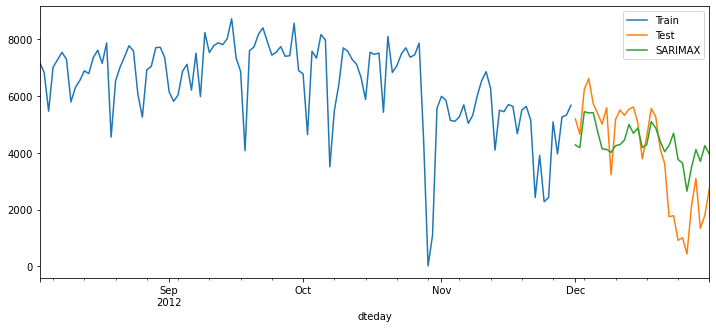

In [16]:
plt.figure(figsize = (12,5))
train['y'][-120:].plot(label = 'Train');   #plotting last few days for better graphs
test['y'].plot(label = 'Test');
preds.plot(label = 'SARIMAX');
plt.legend(loc='best');

In [17]:
print('Average level: ', round(df['y'].mean(),0))
print('MAE:  ', mean_absolute_error(test['y'], preds).round(0))
print('RMSE: ', np.sqrt(mean_squared_error(test['y'], preds)).round(0))
print('MAPE: ', round(((test['y'] - preds)/test['y']).abs().mean()*100,2))

Average level:  4504.0
MAE:   1156.0
RMSE:  1424.0
MAPE:  68.07


In [15]:
preds.to_csv('preds_sarimax.csv')

In [18]:
def fit_model(seasonality):
    model = auto_arima(y = train['y'], X = train_exog, seasonal = True,
                      m = seasonality, n_jobs=-1)
    preds = pd.Series(model.predict(n_periods = test_period, X = test_exog), index=test.index) 
    
    plt.figure(figsize = (12,5))
    train['y'][-120:].plot(label = 'Train');  
    test['y'].plot(label = 'Test');
    preds.plot(label = 'SARIMAX');
    plt.legend(loc='best');
    
    print('Average level: ', round(df['y'].mean(),0))
    print('MAE:  ', mean_absolute_error(test['y'], preds).round(0))
    print('RMSE: ', np.sqrt(mean_squared_error(test['y'], preds)).round(0))
    print('MAPE: ', round(((test['y'] - preds)/test['y']).abs().mean()*100,2))

In [20]:
# fit_model(365) # takes way too long!!

---
### Example 2 - Churrasco dataset

In [25]:
df = pd.read_csv('data/churrasco.csv', index_col='Week', parse_dates=True)

In [26]:
df.head()

,Churrasco,Easter,Carnaval,Republic
Week,,,,
2016-01-31,42,0,0,0
2016-02-07,45,0,1,0
2016-02-14,40,0,0,0
2016-02-21,36,0,0,0
2016-02-28,39,0,0,0


<AxesSubplot:xlabel='Week'>

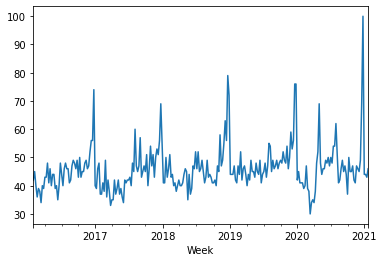

In [28]:
df['Churrasco'].plot()

In [34]:
df.shape

(261, 4)

In [30]:
df.index[:5]

DatetimeIndex(['2016-01-31', '2016-02-07', '2016-02-14', '2016-02-21',
               '2016-02-28'],
              dtype='datetime64[ns]', name='Week', freq=None)

In [32]:
df = df.asfreq('W')
df.index[:5]

DatetimeIndex(['2016-01-31', '2016-02-07', '2016-02-14', '2016-02-21',
               '2016-02-28'],
              dtype='datetime64[ns]', name='Week', freq='W-SUN')

In [33]:
df.isna().sum()

Churrasco    0
Easter       0
Carnaval     0
Republic     0
dtype: int64

In [37]:
test_periods = 10
train = df.iloc[:-test_periods, :]['Churrasco']
test  = df.iloc[-test_periods:, :]['Churrasco']
train_exog = df.iloc[:-test_periods, :].drop(columns='Churrasco')
test_exog  = df.iloc[-test_periods:, :].drop(columns='Churrasco')

In [41]:
model = auto_arima(y = train, 
                   X = train_exog, 
                   m = 52, 
                   seasonal = True)

In [42]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  251
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 52)   Log Likelihood                -777.859
Date:                            Mon, 13 Jun 2022   AIC                           1569.718
Time:                                    22:57:11   BIC                           1594.396
Sample:                                01-31-2016   HQIC                          1579.649
                                     - 11-15-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     14.9841      1.798      8.335      0.000      11.461      18.508
Easter        -1.0038      3.262     -0.308      0.758      -7.398       5.390
Carnaval       6.3600      3.413      1.864      0.062      -0.328      13.048
Republic      12.2020      1.455      8.385      0.000       9.350      15.054
ar.L1          0.4000      0.042      9.439      0.000       0.317       0.483
ar.S.L52       0.4593      0.046      9.940      0.000       0.369       0.550
sigma2        27.9660      2.209     12.660      0.000      23.636      32.296
===================================================================================
Ljung-Box (L1) (Q):                   0.24   Jarque-Bera (JB):               106.75
Prob(Q):                              0.62   Prob(JB):                         0.00
Heteroskedasticity (H):               1.13   Skew:                             0.79
Prob(H) (two-sided):                  0.58   Kurtosis:                         5.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [43]:
preds = pd.Series(model.predict(n_periods = test_periods, X = test_exog), 
                  index=test.index)

In [54]:
preds[:5]

Week
2020-11-22    41.016031
2020-11-29    49.301524
2020-12-06    48.206623
2020-12-13    50.248667
2020-12-20    59.699716
Freq: W-SUN, dtype: float64

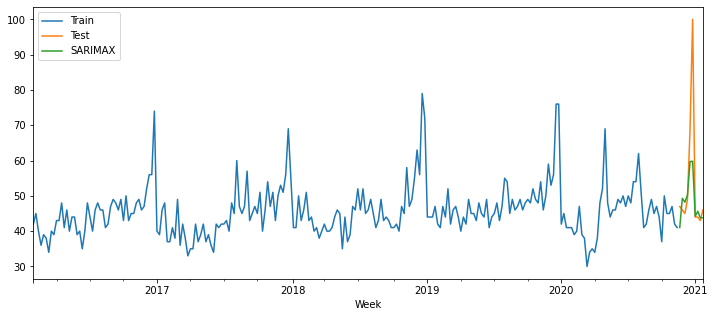

In [46]:
plt.figure(figsize = (12,5))
train.plot(label = 'Train');
test.plot(label = 'Test');
preds.plot(label = 'SARIMAX');
plt.legend(loc='best');

In [53]:
print('Average level: ', round(df['Churrasco'].mean(),0))
print('MAE:  ', mean_absolute_error(test, preds).round(0))
print('RMSE: ', np.sqrt(mean_squared_error(test, preds)).round(0))
print('MAPE: ', round(((test - preds)/test).abs().mean()*100,2))

Average level:  46.0
MAE:   7.0
RMSE:  13.0
MAPE:  9.41


### Check - similar/marginally poorer results with Holt Winters

In [70]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

model_hw = ExponentialSmoothing(endog = train,
                                trend = 'add', seasonal = 'mul', seasonal_periods = 52).fit()

preds_hw = model_hw.forecast(steps=test_periods).rename('HW')

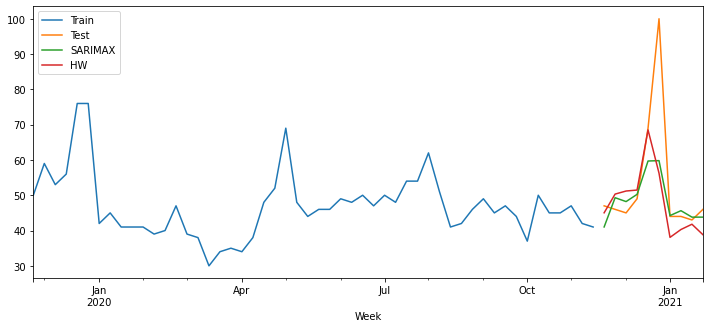

In [71]:
plt.figure(figsize = (12,5))
train[-52:].plot(label = 'Train');
test.plot(label = 'Test');
preds.plot(label = 'SARIMAX');
preds_hw.plot(label = 'HW');
plt.legend(loc='best');

In [72]:
print('Average level: ', round(df['Churrasco'].mean(),0))
print('MAE:  ', mean_absolute_error(test, preds_hw).round(0))
print('RMSE: ', np.sqrt(mean_squared_error(test, preds_hw)).round(0))
print('MAPE: ', round(((test - preds_hw)/test).abs().mean()*100,2))

Average level:  46.0
MAE:   8.0
RMSE:  14.0
MAPE:  11.72


In [78]:
model_hw.summary()

Dep. Variable:,Churrasco,No. Observations:,251
Model:,ExponentialSmoothing,SSE,4189.489
Optimized:,True,AIC,818.535
Trend:,Additive,BIC,1015.961
Seasonal:,Multiplicative,AICC,854.181
Seasonal Periods:,52,Date:,"Mon, 13 Jun 2022"
Box-Cox:,False,Time:,23:14:18
Box-Cox Coeff.:,None,,
,coeff,code,optimized
smoothing_level,0.2886943,alpha,True
smoothing_trend,3.95e-12,beta,True


The End